# Feature Importance

In [1]:
! pip install catboost
! pip install dill
! pip install --upgrade pip
! pip install altair
! pip install --upgrade scikit-learn

    100% |████████████████████████████████| 60.8MB 849kB/s 
    100% |████████████████████████████████| 17.3MB 2.9MB/s 
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 153kB 14.3MB/s 
  Running setup.py bdist_wheel for dill ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
Successfully built dill
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 1.4MB 22.2MB/s 
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
     |████████████████████████████████| 593kB 1

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import dill
import math
import random

import altair as alt
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import feature_selection as fs

from catboost import Pool, CatBoostRegressor, cv
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RepeatedKFold, KFold
from sklearn.metrics import r2_score, mean_squared_error, make_scorer

# for accessing S3 objects
import boto3
import pandas as pd
from sagemaker import get_execution_role

# Debug Flags

In [3]:
# setting flags
debug=False
if debug == True: 
    seed = 10 
    samples = 25000 # 25k records
else: 
    seed=np.random.randint(100000)
    samples = 100000 # 100k records
    
num_features = 10

# Load Files

In [4]:
role = get_execution_role()
bucket='nuras-play'
train_data_key = 'rmit/math2319-machine-learning/advertising_train.csv'
test_data_key = 'rmit/math2319-machine-learning/advertising_test.csv'
save_data_key = 'rmit/math2319-machine-learning/saves/catboost.pkl'

In [5]:
train_data_location = 's3://{}/{}'.format(bucket, train_data_key)
test_data_location = 's3://{}/{}'.format(bucket, test_data_key)
save_data_location = 's3://{}/{}'.format(bucket, save_data_key)

In [6]:
raw_train_data = pd.read_csv(train_data_location,
                       dtype={'companyId':str,'countryId':str,'deviceType':str,'day':str,'dow':str,'price1':np.float64,
                              'price2':np.float64,'price3':np.float64,'ad_area':np.float64,'ad_ratio':np.float64,'requests':np.float64,'impression':np.float64,
                              'cpc':np.float64,'ctr':np.float64,'viewability':np.float64,'ratio1':np.float64,'ratio2':np.float64,'ratio3':np.float64,
                              'ratio4':np.float64,'ratio5':np.float64,'y':np.float64})
                             
raw_test_data = pd.read_csv(test_data_location,
                       dtype={'companyId':str,'countryId':str,'deviceType':str,'day':str,'dow':str,'price1':np.float64,
                              'price2':np.float64,'price3':np.float64,'ad_area':np.float64,'ad_ratio':np.float64,'requests':np.float64,'impression':np.float64,
                              'cpc':np.float64,'ctr':np.float64,'viewability':np.float64,'ratio1':np.float64,'ratio2':np.float64,'ratio3':np.float64,
                              'ratio4':np.float64,'ratio5':np.float64,'y':np.float64})

# One Hot Encoding

In [7]:
hot_train_data = raw_train_data.copy()
hot_test_data = raw_test_data.copy()

test_country = raw_test_data['countryId'].unique()

hot_train_data = hot_train_data[hot_train_data.countryId.isin(test_country)]
print(hot_train_data.shape)

cat_columns = ['companyId','countryId','deviceType','day','dow']

hot_train_data_y = hot_train_data['y']
hot_train_data_x = hot_train_data.drop('y', axis=1)

(213534, 21)


In [8]:
hot_train_data_x = pd.get_dummies(hot_train_data_x, prefix_sep="__",columns=cat_columns)

cat_dummies = [col for col in hot_train_data_x 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

processed_columns = list(hot_train_data_x.columns[:])

# Remove additional columns
for col in hot_test_data.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        #print("Removing additional feature {}".format(col))
        hot_test_data.drop(col, axis=1, inplace=True)
        
for col in cat_dummies:
    if col not in hot_test_data.columns:
        #print("Adding missing feature {}".format(col))
        hot_test_data[col] = 0        
        
hot_test_data = hot_test_data[processed_columns]
#hot_train_data = hot_train_data_x.join(hot_train_data_y)
hot_train_data = hot_train_data_x
hot_train_data.shape

(213534, 200)

# Data Transformation

In [9]:
robust_scaler = RobustScaler(quantile_range=(10.0, 90.0)).fit(hot_train_data)
trans_train_data = robust_scaler.transform(hot_train_data)
trans_test_data = robust_scaler.transform(hot_test_data)
print(trans_train_data.shape)
print(trans_test_data.shape)

(213534, 200)
(30910, 200)


In [10]:
processed_columns_with_y = processed_columns.copy()
processed_columns_with_y.append('y')
#trans_train_data_df = pd.DataFrame(trans_train_data,columns=processed_columns_with_y)
trans_train_data_df = pd.DataFrame(trans_train_data,columns=processed_columns)

# Feature Selection Using F-Score

In [11]:
fs_fit_fscore = fs.SelectKBest(fs.f_regression, k=num_features)
fs_fit_fscore.fit_transform(trans_train_data_df.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed))
fs_indices_fscore = np.argsort(fs_fit_fscore.scores_)[::-1][0:num_features]
fs_indices_fscore

best_features_fscore = trans_train_data_df.columns[fs_indices_fscore].values
best_features_fscore

feature_importances_fscore = fs_fit_fscore.scores_[fs_indices_fscore]
feature_importances_fscore

array([4595.60900096, 4254.23482272, 3105.27036396, 2809.00167163,
       2574.12633092, 2552.40699589, 1835.25265163, 1655.67060763,
       1453.0248496 , 1087.29016909])

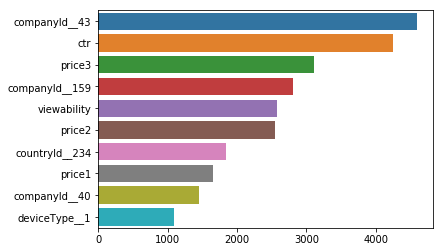

In [12]:
ax = sns.barplot(x=feature_importances_fscore, y=best_features_fscore)

# Feature using RFI

In [13]:
samples = 100000
model_rfi =  RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
model_rfi.fit(trans_train_data_df, hot_train_data_y)


RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

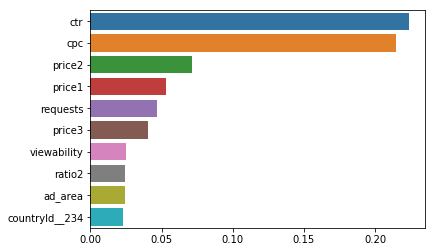

In [14]:
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]
best_features_rfi = trans_train_data_df.columns[fs_indices_rfi].values
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
ax = sns.barplot(x=feature_importances_rfi, y=best_features_rfi)

# Feature Selection Using SPSA

In [15]:
from SpFtSel import SpFtSel

wrapper =  RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

sp_engine = SpFtSel(trans_train_data_df.sample(samples, random_state = seed).values, 
                    hot_train_data_y.sample(samples, random_state = seed), 
                    wrapper, 'neg_mean_squared_error')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
np.random.seed(seed)
sp_output = sp_engine.run(10,stratified_cv=False).results

spFtSel-INFO: Algorithm run mode: regular
spFtSel-INFO: Wrapper: RandomForestRegressor(bootstrap='False', criterion='mse', max_depth=30,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
spFtSel-INFO: Scoring metric: neg_mean_squared_error
spFtSel-INFO: Number of features: 200
spFtSel-INFO: Number of observations: 100000
spFtSel-INFO: iter: 0, value: -1.927, std: 0.054, num. features: 10, best value: -1.927
spFtSel-INFO: iter: 5, value: -1.882, std: 0.106, num. features: 10, best value: -1.878
spFtSel-INFO: iter: 10, value: -1.813, std: 0.066, num. features: 10, best value: -1.813
spFtSel-INFO: iter: 15, value: -1.84, std: 0.071, num. features: 10, be

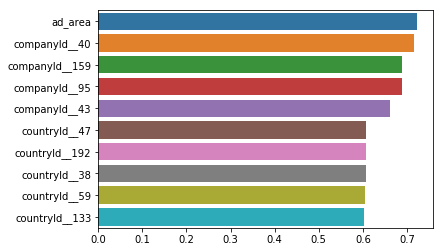

In [17]:
fs_indices_spsa = sp_output.get('features')
fs_indices_spsa
best_features_spsa = trans_train_data_df.columns[fs_indices_spsa].values
best_features_spsa
feature_importances_spsa = sp_output.get('importance')
feature_importances_spsa
ax = sns.barplot(x=feature_importances_spsa, y=best_features_spsa)

# Features using Mutual Importance

In [18]:
samples = 25000 # resetting sample because of how long it takes to run
fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_regression, k=num_features)
fs_fit_mutual_info.fit_transform(trans_train_data_df.sample(samples, random_state = seed), 
                            hot_train_data_y.sample(samples, random_state = seed))


array([[-8.84955752e-03, -5.38922156e-02, -1.11556800e-01, ...,
        -9.66297431e-03,  3.98129813e+00,  5.67046450e-01],
       [-8.84955752e-03, -5.38922156e-02, -1.11556800e-01, ...,
        -3.74734857e-02, -1.87018702e-02, -3.64154251e-01],
       [ 0.00000000e+00,  1.19760479e-01,  1.04139862e-01, ...,
         3.33443318e+00, -1.21012101e-02, -3.35451358e-01],
       ...,
       [ 6.19469027e-02,  3.59281437e-02,  0.00000000e+00, ...,
         1.76526043e-01,  7.70077008e-03, -1.32340053e-01],
       [ 4.24778761e-01,  4.01197605e-01,  4.60796186e-01, ...,
         1.03464530e-01,  2.12321232e-01,  3.68755478e-01],
       [-8.84955752e-03, -5.38922156e-02, -1.11556800e-01, ...,
        -2.82818760e-03,  3.64796480e+00,  2.74868536e-01]])

In [19]:
fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:num_features]
best_features_mutual_info = trans_train_data_df.columns[fs_indices_mutual_info].values
mutal_info_scores = fs_fit_mutual_info.scores_[::-1][0:num_features]
feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]
feature_importances_mutual_info

array([0.19591737, 0.18599883, 0.1328392 , 0.09214925, 0.08320799,
       0.06855907, 0.06631189, 0.06073871, 0.05392177, 0.05167132])

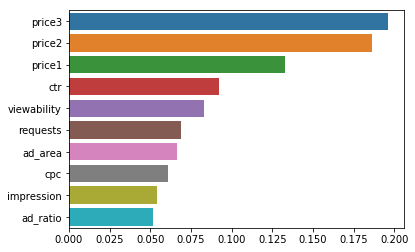

In [20]:
ax = sns.barplot(x=feature_importances_mutual_info, y=best_features_mutual_info)